In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
sample_submission = pd.read_csv(dirname+"/"+filenames[0])
train_dataset = pd.read_csv(dirname+"/"+filenames[1])
test_dataset = pd.read_csv(dirname+"/"+filenames[2])



In [ ]:
train_dataset.head(50)

In [ ]:
servers = train_dataset.groupby(train_dataset['SERVER'] == "CIHAZ_301")

first_server = servers.get_group(True)
second_server = servers.get_group(False)

In [ ]:
first_server_y = first_server.pivot(columns='CPU', values='CPULOAD')
second_server_y = first_server.pivot(columns='CPU', values='CPULOAD')

first_server = first_server.pivot(index='DATETIME', columns='CPU', values='CPULOAD')


second_server = second_server.pivot(index = 'DATETIME', columns = 'CPU', values = 'CPULOAD')

first_server_mean = first_server.mean(axis=1)
second_server_mean = second_server.mean(axis=1)



In [ ]:
first_server.fillna(method= 'ffill',inplace = True)
second_server.fillna(method= 'ffill',inplace = True)

In [ ]:
first_server.head()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
first_server_mean.head()

In [ ]:
forecasts = {}
all_predictions = pd.DataFrame(columns=['DATETIME', 'CPU', 'CPULOAD'])


data = first_server_mean



model = SARIMAX(data, order=(1,2,1), seasonal_order=(0,1,0,96))
forecast_start = pd.to_datetime('2020-05-30 23:45:00+03:00')
forecast_end = pd.to_datetime('2020-05-31 23:45:00+03:00')
forecast_range = pd.date_range(forecast_start, forecast_end, freq='15min')
    

model_fit = model.fit(disp=0)

predictions = model_fit.get_forecast(len(forecast_range)).predicted_mean
    #predictions = model_fit.predict(start=start, end=end ,freq='15min')

predictions_first = pd.DataFrame(predictions, columns=['CPULOAD'])


In [ ]:
predictions = model_fit.get_forecast(len(forecast_range)).predicted_mean

predictions.head(50)

predictions_first = pd.DataFrame(predictions.values, columns=['CPULOAD'])

predictions_first.head(50)

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(20,14))
plt.plot(predictions_first.values, label='Predictions')
plt.xlabel('Date and Time')
plt.ylabel('CPU Load')
plt.title('Forecasts for CPU Loads on May 31st')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
new_columns = ['DATETIME','Cpu ID','CPU Load']
submit_first_server = all_predictions.drop([c for c in all_predictions.columns if c not in new_columns],axis=1)
submit_first_server

In [ ]:
forecasts_server2 = {}
all_predictions_server2 = pd.DataFrame(columns=['DATETIME', 'CPU', 'CPULOAD'])


data = second_server_mean



model = SARIMAX(data, order=(1,2,1), seasonal_order=(0,1,0,96))
forecast_start = pd.to_datetime('2020-05-30 23:45:00+03:00')
forecast_end = pd.to_datetime('2020-05-31 23:45:00+03:00')
forecast_range = pd.date_range(forecast_start, forecast_end, freq='15min')
    

model_fit = model.fit(disp=0)

predictions_second = model_fit.get_forecast(len(forecast_range)).predicted_mean
    #predictions = model_fit.predict(start=start, end=end ,freq='15min')


forecasts_server2 = pd.DataFrame(predictions_second.values, columns=['CPULOAD'])








import matplotlib.pyplot as plt
plt.figure(figsize=(20,14))
plt.plot(forecasts_server2, label='Predictions')
plt.xlabel('Date and Time')
plt.ylabel('CPU Load')
plt.title('Forecasts for CPU Loads on May 31st')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
predictions_first['SERVER'] = 'CIHAZ_301'
forecasts_server2['SERVER'] = 'CIHAZ_305'

datetimed_first = pd.to_datetime(predictions_first.index)

frames = [predictions_first,forecasts_server2]

result = pd.concat(frames)

result

In [ ]:
#create new dataframe and add predictions, server and datetime columns
datetimed = predictions_first
datetimed['SERVER'] = 'CIHAZ_301'
datetimed['DATETIME'] = forecast_range



datetimed_second = forecasts_server2
datetimed_second['SERVER'] = 'CIHAZ_305'
datetimed_second['DATETIME'] = forecast_range

datetimed_second
frames = [datetimed,datetimed_second]

result = pd.concat(frames)
result = result.sort_values(by='DATETIME',ascending=True)

In [31]:
#result.sort_index(ascending=True)
resultcopy = result.copy()

In [33]:
resultcopy

,CPULOAD,SERVER,DATETIME
0,5.615052,CIHAZ_301,2020-05-30 23:45:00+03:00
0,9.208872,CIHAZ_305,2020-05-30 23:45:00+03:00
1,4.599361,CIHAZ_301,2020-05-31 00:00:00+03:00
1,6.921037,CIHAZ_305,2020-05-31 00:00:00+03:00
2,4.061453,CIHAZ_301,2020-05-31 00:15:00+03:00
...,...,...,...
94,5.524654,CIHAZ_301,2020-05-31 23:15:00+03:00
95,7.953206,CIHAZ_305,2020-05-31 23:30:00+03:00
95,5.249977,CIHAZ_301,2020-05-31 23:30:00+03:00
96,5.208686,CIHAZ_301,2020-05-31 23:45:00+03:00


In [56]:
new_columns = ['CPULOAD']
submit_first_server = resultcopy.drop([c for c in resultcopy.columns if c not in new_columns],axis=1)
submit_first_server= submit_first_server.tail(-1)
submit_first_server = submit_first_server.tail(-1)
submit_first_server = submit_first_server.reset_index(drop=True)
submit_first_server

,CPULOAD
0,4.599361
1,6.921037
2,4.061453
3,6.012191
4,3.926219
...,...
187,5.524654
188,7.953206
189,5.249977
190,5.208686


In [57]:
submit_first_server.rename(columns={0: "index"}, inplace=True)
submit_first_server.to_csv('submission.csv',index=True)

In [58]:
submit_first_server

,CPULOAD
0,4.599361
1,6.921037
2,4.061453
3,6.012191
4,3.926219
...,...
187,5.524654
188,7.953206
189,5.249977
190,5.208686


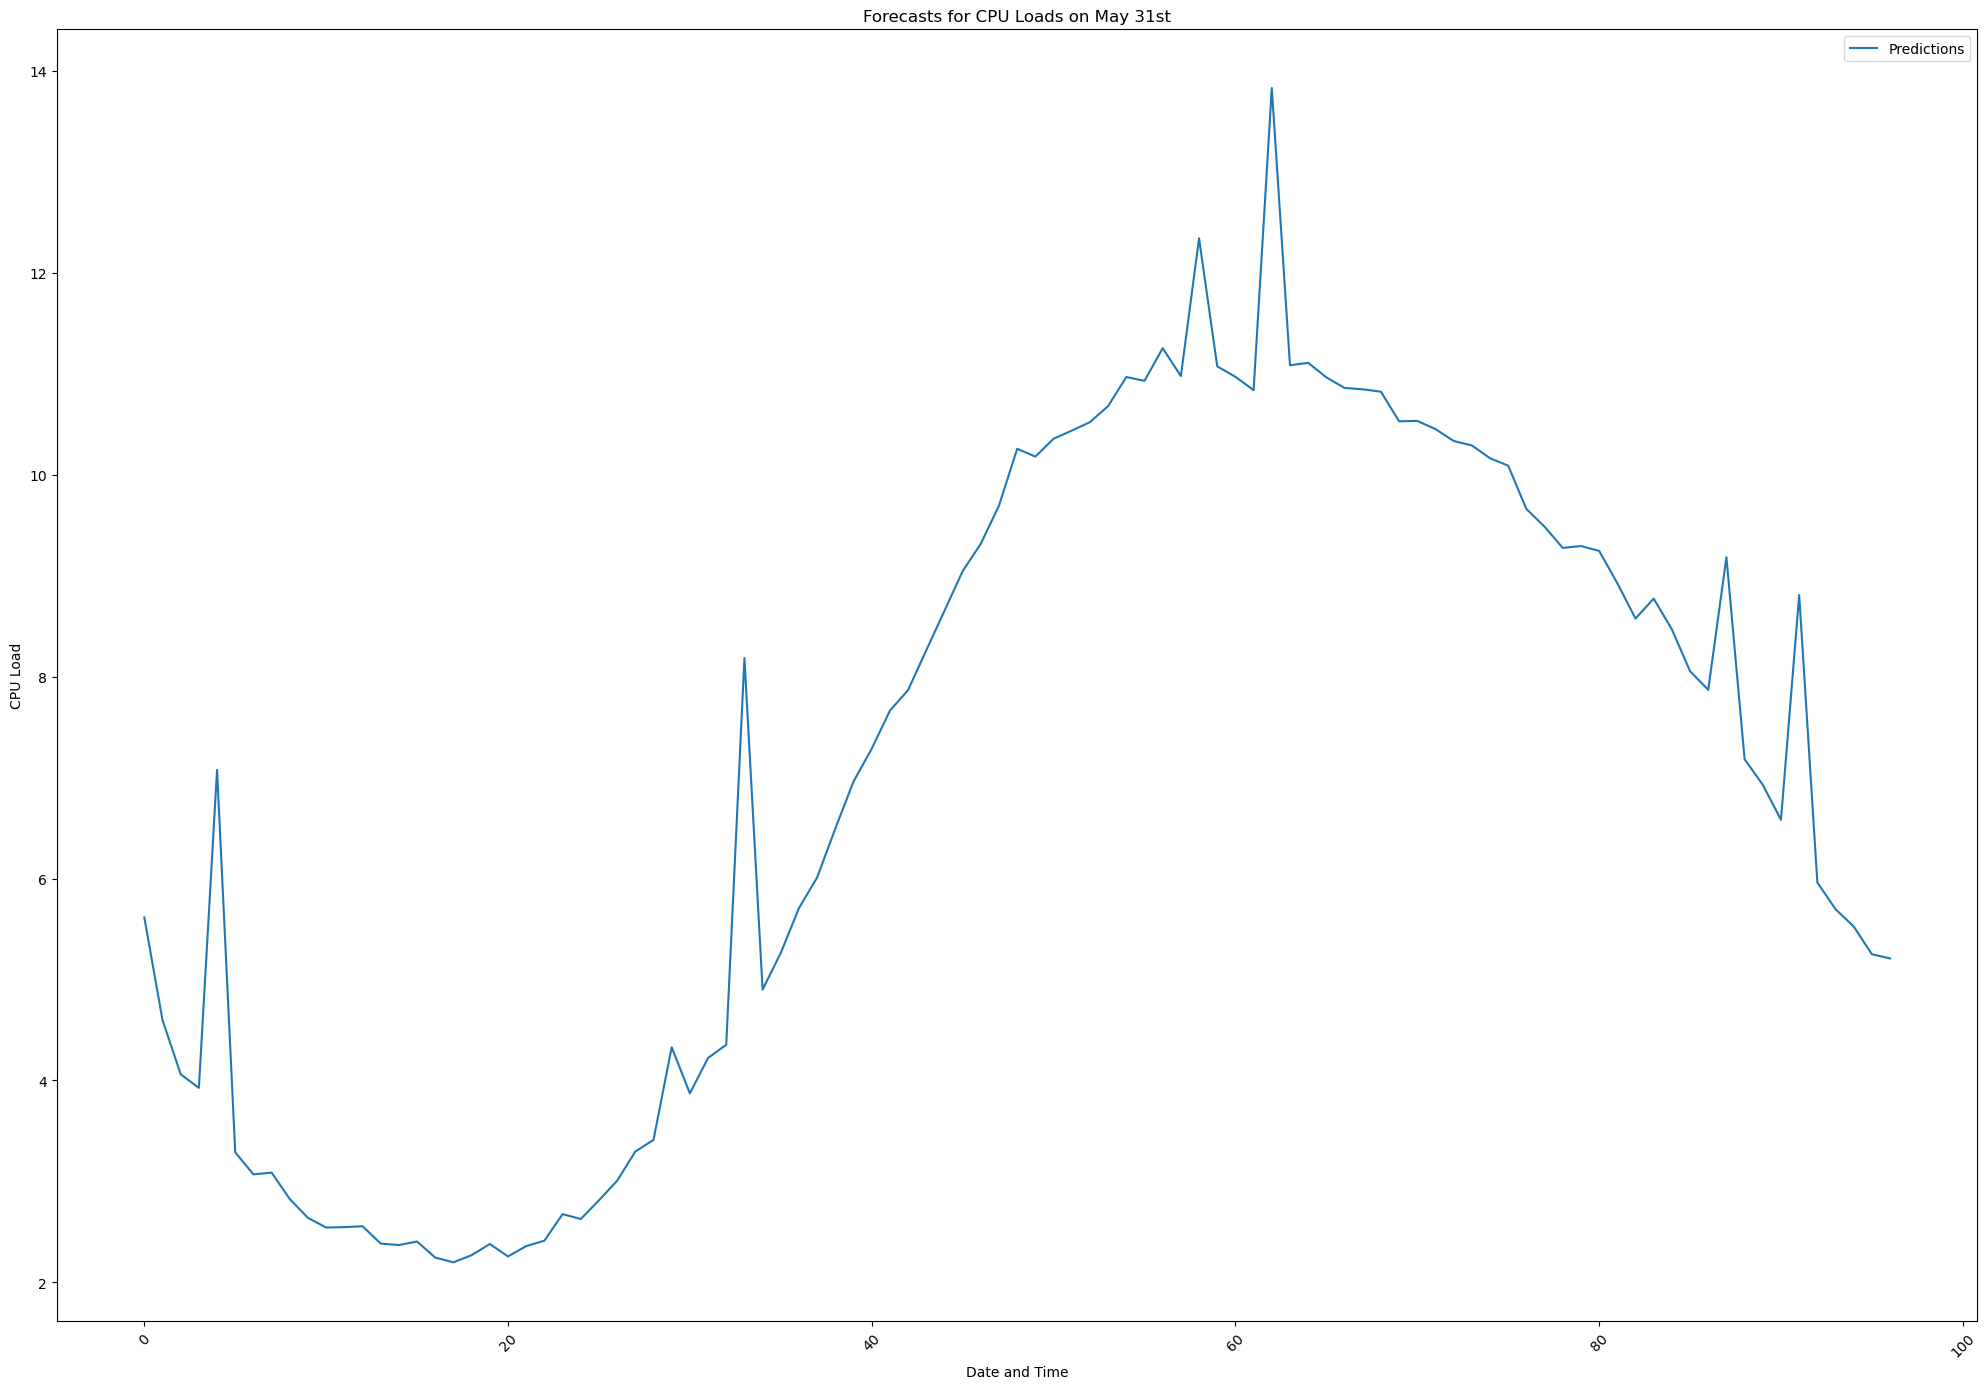

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,14))
plt.plot(datetimed['CPULOAD'], label='Predictions')
plt.xlabel('Date and Time')
plt.ylabel('CPU Load')
plt.title('Forecasts for CPU Loads on May 31st')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

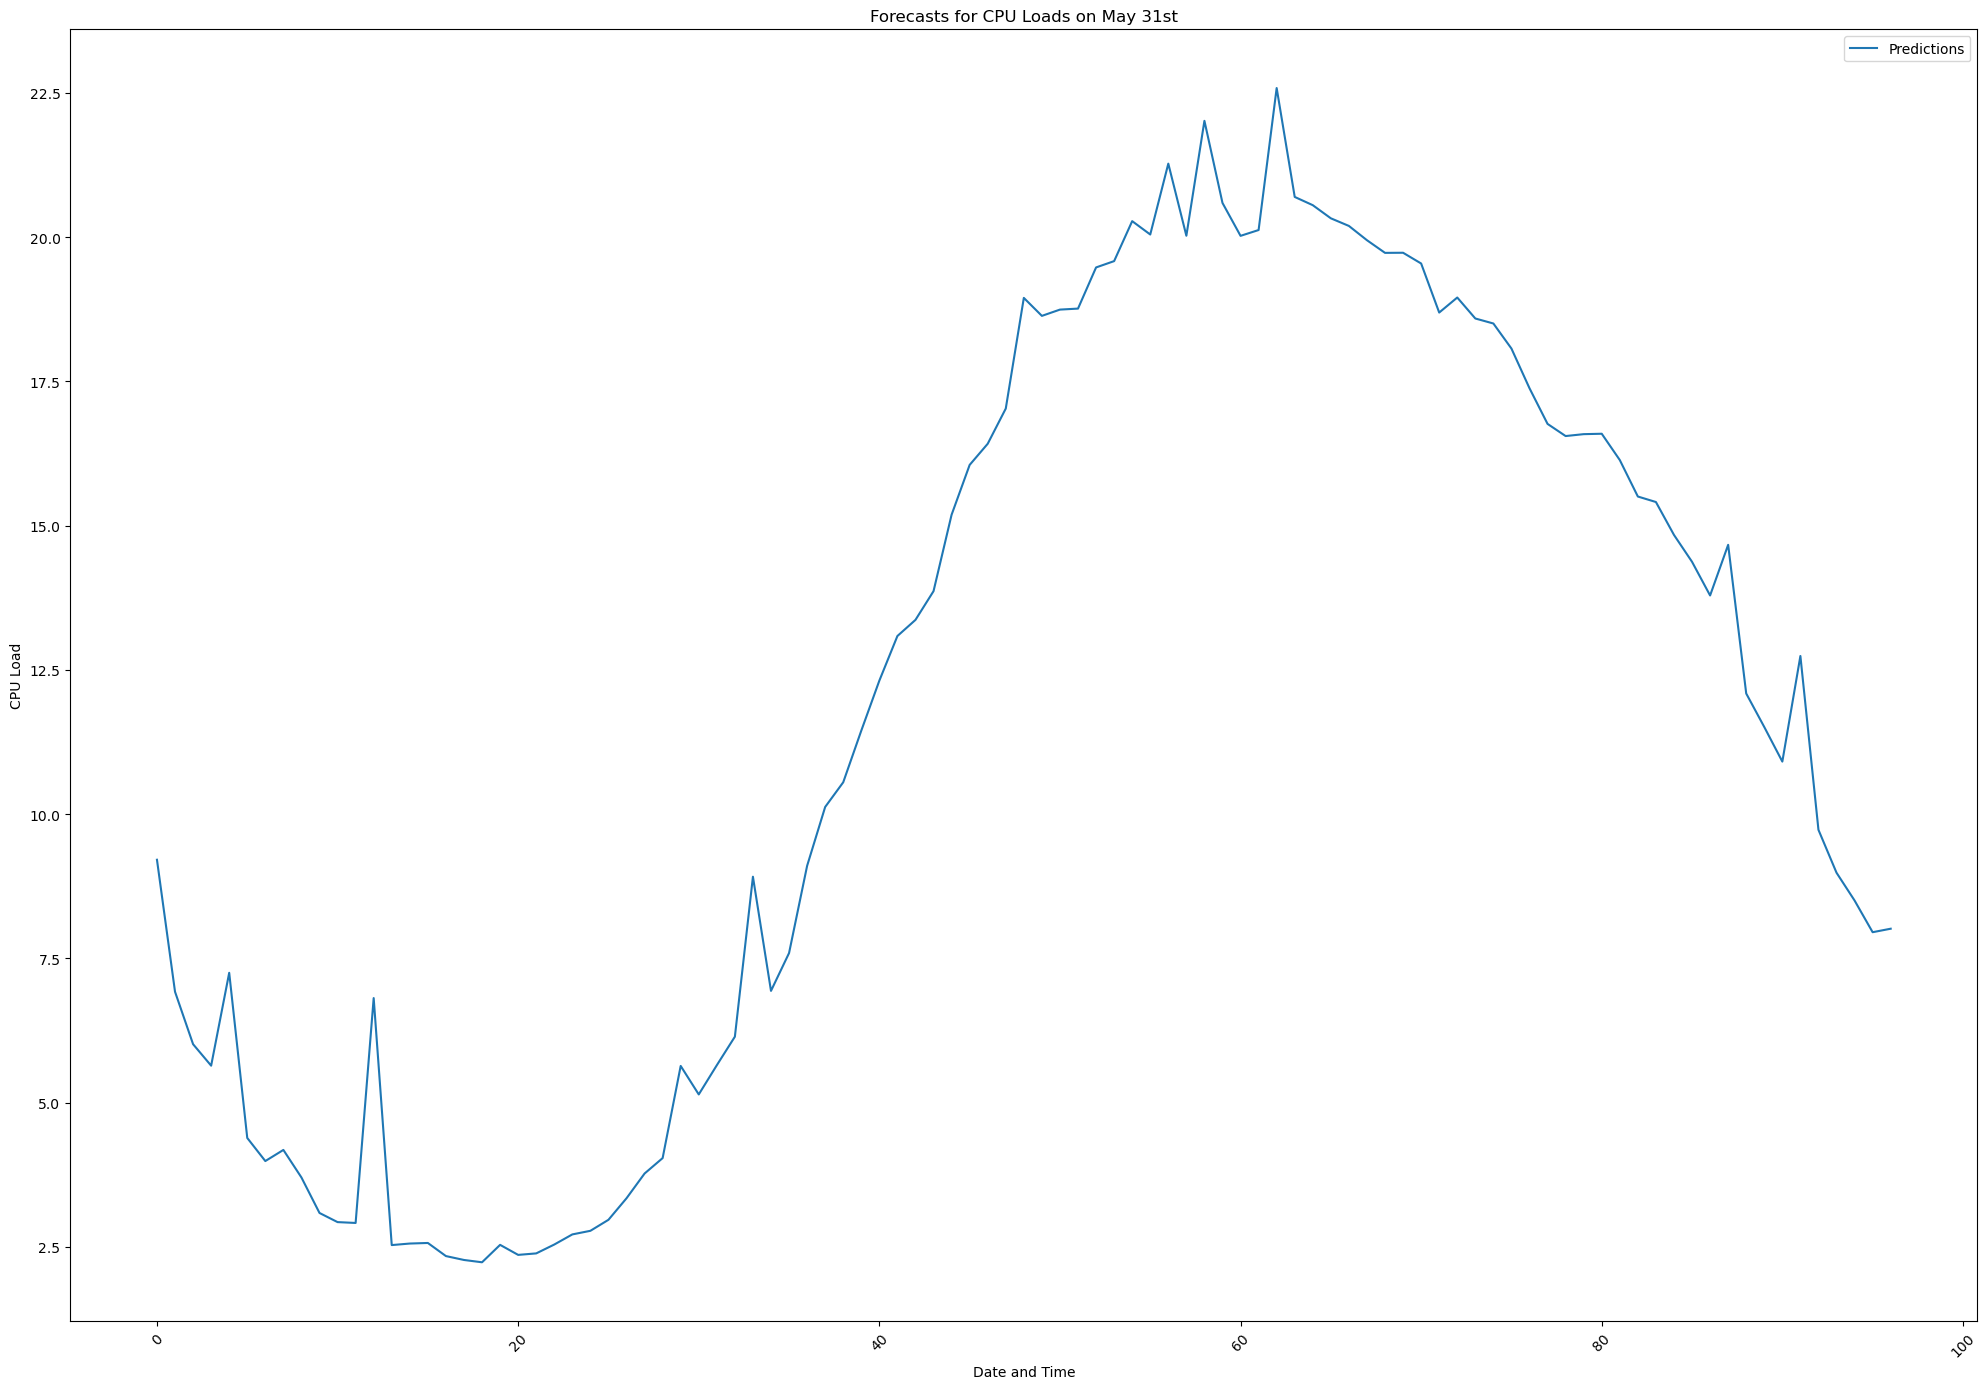

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,14))
plt.plot(datetimed_second['CPULOAD'], label='Predictions')
plt.xlabel('Date and Time')
plt.ylabel('CPU Load')
plt.title('Forecasts for CPU Loads on May 31st')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()